# Cython: A First Look

## Some Jupyter lab notes:
* Jupyter lab let's us make cells and run code in a nicely formatted way
* We also can use things like magic cells - these allow us to do special operations on code
* Rerunning cells is super easy
* For Cython - the notebook abstracts all of the compilation away
* Also for Cython - allows you to profile your code

## Typical sieve algorithm:

1. Create a list of integers 2 -> N
2. Start at 2, all factors of it are marked in the list as non-prime (false)
3. Go to next true index
4. Mark all factors of it in the list as false
5. Go to step 3
6. All remaining true indices are prime numbers

Here's a basic sieve implementation. Nothing special.

Might not even be the most efficient!

In [1]:
def sieve(sieve_length):
    sieve_table = [True for x in range(sieve_length)]
    sieve_table[0] = False
    sieve_table[1] = False
    
    for i in range(2,int(sieve_length**0.5)+1):
        if sieve_table[i]:
            for marker in range(i*i, sieve_length, i):
                sieve_table[marker] = False
    
    return [i for i, t in enumerate(sieve_table) if t]

Testing base functionality:

In [2]:
primes = sieve(1_000)
print(','.join([str(p) for p in primes]))

2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97,101,103,107,109,113,127,131,137,139,149,151,157,163,167,173,179,181,191,193,197,199,211,223,227,229,233,239,241,251,257,263,269,271,277,281,283,293,307,311,313,317,331,337,347,349,353,359,367,373,379,383,389,397,401,409,419,421,431,433,439,443,449,457,461,463,467,479,487,491,499,503,509,521,523,541,547,557,563,569,571,577,587,593,599,601,607,613,617,619,631,641,643,647,653,659,661,673,677,683,691,701,709,719,727,733,739,743,751,757,761,769,773,787,797,809,811,821,823,827,829,839,853,857,859,863,877,881,883,887,907,911,919,929,937,941,947,953,967,971,977,983,991,997


Everything appears to be working, but how fast is it?

Time for some basic benchmarking!

In [3]:
%timeit sieve(1_000_000)

143 ms ± 8.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%timeit sieve(10_000_000)

1.95 s ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Anecdotally - I happen to know this is pretty slow.

## First steps into Cython

In [5]:
%load_ext Cython

In [6]:
%%cython

def sieve_magic(sieve_length):
    sieve_table = [True for x in range(sieve_length)]
    sieve_table[0] = False
    sieve_table[1] = False
    
    for i in range(2,int(sieve_length**0.5)+1):
        if sieve_table[i]:
            for marker in range(i*i, sieve_length, i):
                sieve_table[marker] = False
    
    return [i for i, t in enumerate(sieve_table) if t]

In [7]:
primes_magic = sieve_magic(1_000)
print(','.join([str(p) for p in primes_magic]))

2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97,101,103,107,109,113,127,131,137,139,149,151,157,163,167,173,179,181,191,193,197,199,211,223,227,229,233,239,241,251,257,263,269,271,277,281,283,293,307,311,313,317,331,337,347,349,353,359,367,373,379,383,389,397,401,409,419,421,431,433,439,443,449,457,461,463,467,479,487,491,499,503,509,521,523,541,547,557,563,569,571,577,587,593,599,601,607,613,617,619,631,641,643,647,653,659,661,673,677,683,691,701,709,719,727,733,739,743,751,757,761,769,773,787,797,809,811,821,823,827,829,839,853,857,859,863,877,881,883,887,907,911,919,929,937,941,947,953,967,971,977,983,991,997


In [8]:
%timeit sieve_magic(1_000_000)

90.9 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Exploring with Cython

Cython gives us the ability to view how our code has compiled!

Let's try it:

In [9]:
%%cython

def sieve_working(int sieve_length):
    sieve_table = [True for x in range(sieve_length)]
    sieve_table[0] = False
    sieve_table[1] = False
    
    cdef int i, marker
    cdef int upper
    upper = int(sieve_length**0.5) + 1
    
    for i in range(2,int(sieve_length**0.5)+1):
        if sieve_table[i]:
            for marker in range(i*i, sieve_length, i):
                sieve_table[marker] = False
    
    return [i for i, t in enumerate(sieve_table) if t]

In [10]:
%timeit sieve_working(1_000_000)

53.1 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We've still got quite a bit of yellow - but things are faster for sure!

# Splitting things up

It looks like working on these list comprehensions is going to be a struggle... Let's split some things up.

In [11]:
%%cython
import cython

def sieve_table_cy(int sieve_length):
    sieve_table = [True for x in range(sieve_length)]
    sieve_table[0] = False
    sieve_table[1] = False
    
    cdef int i, marker
    cdef int upper
    upper = int(sieve_length**0.5) + 1
    
    for i in range(2, upper):
        if sieve_table[i]:
            for marker in range(i*i, sieve_length, i):
                sieve_table[marker] = False
    
    return sieve_table

def sieve_print_cy(table):
    cdef int i
    cdef int t
    cdef list primes
    primes = []
    for i in range(len(table)):
        if table[i]:
            primes.append(i)
    return primes

In [12]:
%%timeit
table = sieve_table_cy(1_000_000)
# table = sieve_table_cy(1_000)
prime_list = sieve_print_cy(table)

58.4 ms ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
table = sieve_table_cy(50_000_000)
# table = sieve_table_cy(1_000)
prime_list = sieve_print_cy(table)

6.34 s ± 91.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In the comparison case: not really faster - but we can see what needs to be done much better

# Calling STL Functions

At this point we know that there's more we can do with that inner for loop - but let's have a look at the list access that's being done.

Why don't we replace it with a C++ structure?

In [14]:
%reload_ext Cython

In [15]:
%%cython
# distutils: language=c++

import cython

from libcpp.vector cimport vector

def do_stuff():
    cdef vector[int] totally_a_list
    totally_a_list.push_back(100)
    return totally_a_list[0]

In [16]:
do_stuff()

100

that was easy! Let's rewrite our previous code now.

In [17]:
%%cython
# distutils: language=c++

import cython

from libcpp.vector cimport vector

def sieve_table_vec(int sieve_length):
    cdef vector[int] sieve_table
    sieve_table.resize(sieve_length, 1)
    sieve_table[0] = 0
    sieve_table[1] = 0
    
    cdef int i, marker
    cdef int upper
    upper = int(sieve_length**0.5) + 1
    for i in range(2, upper):
        if sieve_table[i]:
            for marker in range(i*i, sieve_length, i):
                sieve_table[marker] = 0
    
    return sieve_table

def sieve_print_vec(table):
    cdef int i
    cdef vector[int] primes
    for i in range(len(table)):
        if table[i]:
            primes.push_back(i)
    return primes

In [18]:
%%timeit
table = sieve_table_vec(1_000_000)
# table = sieve_table_vec(1_000)
prime_list = sieve_print_vec(table)

39.5 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
table = sieve_table_vec(50_000_000)
# table = sieve_table_vec(1_000)
prime_list = sieve_print_vec(table)

3.09 s ± 565 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Battling the Inner Loop

There's other smaller optimizations to do for sure - but what about that inner for loop?

In [20]:
%%cython
# distutils: language=c++

import cython

from libcpp.vector cimport vector

def sieve_table_fin(int sieve_length):
    cdef vector[int] sieve_table
    sieve_table.resize(sieve_length, 1)
    sieve_table[0] = 0
    sieve_table[1] = 0
    
    cdef int i, marker
    cdef int upper
    upper = int(sieve_length**0.5) + 1
    for i in range(2, upper):
        if sieve_table[i]:
            marker = i*i
            while marker < sieve_length:
                sieve_table[marker] = 0
                marker += i
    
    return sieve_table

def sieve_print_fin(table):
    cdef int i
    cdef vector[int] primes
    for i in range(len(table)):
        if table[i]:
            primes.push_back(i)
    return primes

In [21]:
%%timeit
table = sieve_table_fin(1_000_000)
# table = sieve_table_vec(1_000)
prime_list = sieve_print_fin(table)

20.4 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
table = sieve_table_fin(50_000_000)
# table = sieve_table_vec(1_000)
prime_list = sieve_print_fin(table)

1.42 s ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Quick Graphical Comparison

In [54]:
def compare_approach(problem_size):
    result_base = %timeit -o sieve(problem_size)
    result_raw = %timeit -o sieve_magic(problem_size) # raw compile
    result_annotate = %timeit -o sieve_working(problem_size) # annotation of types
    result_split = %timeit -o sieve_print_cy(sieve_table_cy(problem_size)) # problem split up
    result_stdlib = %timeit -o prime_list = sieve_print_vec(sieve_table_vec(problem_size)) # use stlib
    result_final = %timeit -o table = sieve_print_fin(sieve_table_fin(problem_size)) # final win

    result_dict = {
        'Base Python': result_base.best,
        'Using Cython Raw': result_raw.best,
        'Cython Annotation': result_annotate.best,
        'Splitting Problem': result_split.best,
        'Using C++ stdlib': result_stdlib.best,
        'Final Result': result_final.best
    }

    import plotly.express as px
    import pandas as pd

    fig = px.bar(pd.DataFrame.from_dict(result_dict, orient='index', columns=['Seconds']),
                 title=f'Time Comparison of Sieve Approaches on Size: {problem_size:,}')
    fig.show()

131 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
84.4 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.2 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
83.9 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
44.4 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.7 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


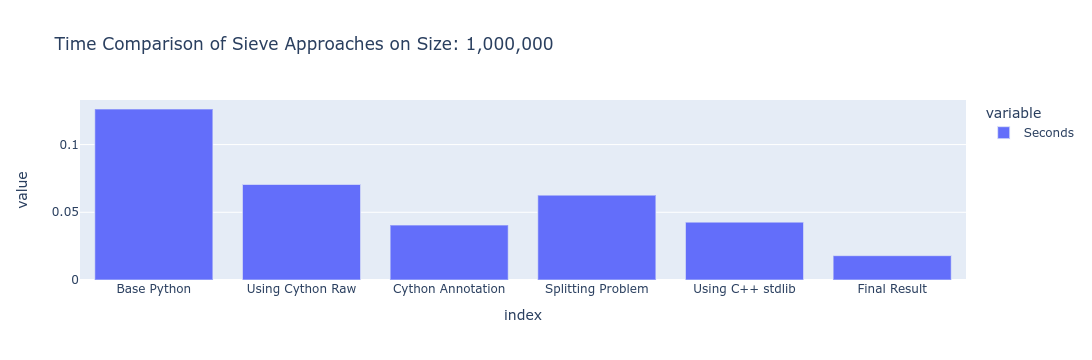

In [55]:
compare_approach(1_000_000)

2.23 s ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.62 s ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.23 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.33 s ± 38.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
570 ms ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
340 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


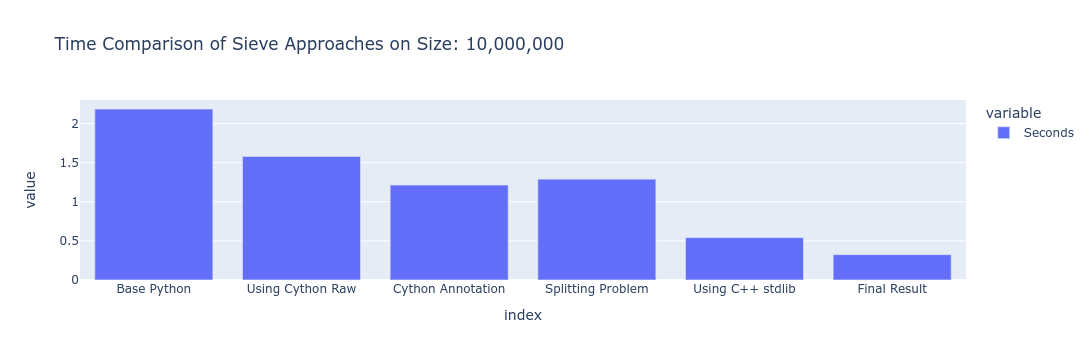

In [56]:
compare_approach(10_000_000)

12.7 s ± 1.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.64 s ± 654 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.09 s ± 239 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.75 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.44 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.52 s ± 32.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


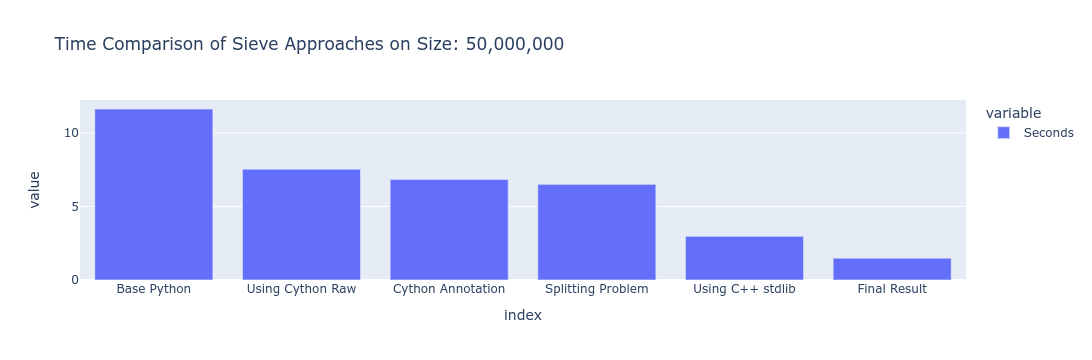

In [57]:
compare_approach(50_000_000)